In [9]:
from primeGraph import Graph, START, END
from primeGraph.models import GraphState
from primeGraph.buffer import History, LastValue
from pydantic import BaseModel
from openai import AsyncOpenAI
import instructor
from IPython.display import Image
from typing import Tuple

from dotenv import load_dotenv

# assumes you have a local .env file with OPENAI_API_KEY set
load_dotenv()

# loading openai client
client = instructor.from_openai(AsyncOpenAI())


# Async workflow


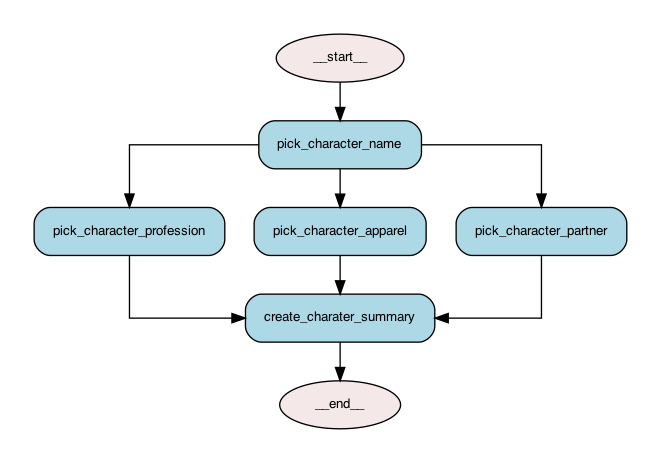

In [21]:
class Character(GraphState):
    character_name: LastValue[str]
    character_items: History[Tuple[str,str]]
    character_summary: LastValue[str]
    
class CharacterName(BaseModel):
    character_name: str

class CharacterSummary(BaseModel):
    character_summary: str

class CharacterItem(BaseModel):
    item_name: str
    item_description: str


character_state = Character(character_name="", character_items=[], character_summary="")
character_graph = Graph(state=character_state, verbose=False)

@character_graph.node()
async def pick_character_name(state):
    res = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": "Pick me a character from Lord of the Rings"}],
        response_model=CharacterName,
    )
    return {"character_name": res.character_name}


@character_graph.node()
async def pick_character_profession(state):
    res = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": "Pick me a profession for the character"}],
        response_model=CharacterItem,
    )
    return {"character_items": (res.item_name, res.item_description)}

@character_graph.node()
async def pick_character_apparel(state):
    res = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": "Pick me a clothing for the character"}],
        response_model=CharacterItem,
    )
    return {"character_items": (res.item_name, res.item_description)}

@character_graph.node()
async def pick_character_partner(state):
    res = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": "Pick me a partner for the character"}],
        response_model=CharacterItem,
    )
    return {"character_items": (res.item_name, res.item_description)}

@character_graph.node()
async def create_charater_summary(state):
    ch_items = "\n".join([f"{item[0]}: {item[1]}" for item in state.character_items])
    res = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": f"Name: {state.character_name} \
        \nItems: {ch_items}"}],
        response_model=CharacterSummary,
    )
    return {"character_summary": res.character_summary}

character_graph.add_edge(START, "pick_character_name")
character_graph.add_edge("pick_character_name", "pick_character_profession")
character_graph.add_edge("pick_character_name", "pick_character_apparel")
character_graph.add_edge("pick_character_name", "pick_character_partner")
character_graph.add_edge("pick_character_profession", "create_charater_summary")
character_graph.add_edge("pick_character_apparel", "create_charater_summary")
character_graph.add_edge("pick_character_partner", "create_charater_summary")
character_graph.add_edge("create_charater_summary", END)

character_graph.compile()
Image(character_graph.visualize(transparent=True).pipe(format='png'))


In [17]:
await character_graph.start_async()

'chain_cf6de100-9dc9-4688-9634-5fa7c7d69434'

Character(
    version='a35efff8c805417e13d4b950e6d7281c',
    character_name='Frodo Baggins',
    character_items=[
        (
            'Mysterious Stranger',
            "A hooded figure who appears at unexpected moments, offering cryptic advice and insight into the 
character's quest."
        ),
        (
            'Mystic Robe',
            "A flowing robe made from shimmering fabric that glimmers with magical energy. It is adorned with 
ancient runes and has a hood that conceals the wearer's face. Perfect for wizards and sorcerers."
        ),
        (
            'Adventurer',
            'A brave explorer who embarks on quests, seeks treasure, and faces challenges in the great unknown.'
        )
    ],
    character_summary='Frodo Baggins is a brave adventurer on a quest, known for exploring the unknown and seeking 
treasure. He is accompanied by a Mysterious Stranger, a hooded figure who offers cryptic advice and insight during 
his journey. Frodo wears a Mystic Robe, a magical garment adorned with ancient runes, which enhances his mystical 
abilities and conceals his identity.'
)